In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
train_data_dir = 'colour_train'
colours = os.listdir(train_data_dir)
print(colours)

['Black', 'Blue', 'Green', 'Red', 'White', 'Yellow']


In [3]:
num_labels = len(colours)

colour_to_label = {
    colour: idx for idx, colour in enumerate(colours)
}

label_to_colour = {
    idx: colour for idx, colour in enumerate(colours)
}

print(num_labels)
print(colour_to_label)
print(label_to_colour)


6
{'Black': 0, 'Blue': 1, 'Green': 2, 'Red': 3, 'White': 4, 'Yellow': 5}
{0: 'Black', 1: 'Blue', 2: 'Green', 3: 'Red', 4: 'White', 5: 'Yellow'}


In [4]:
def random_pick() -> tuple[np.ndarray, int]:
    colour = random.choice(colours)
    img_fnames = os.listdir(f'{train_data_dir}/{colour}')
    img_path = f'{train_data_dir}/{colour}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = colour_to_label[colour]
    return img, label

image_shape=(224, 224, 3)


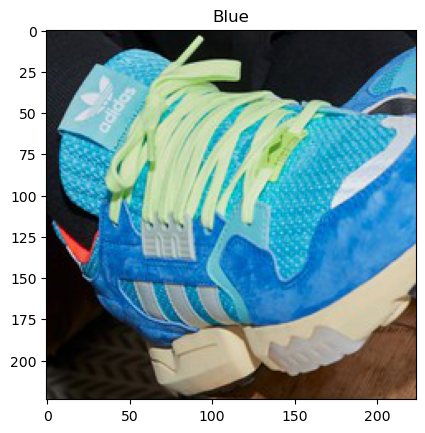

In [5]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_colour[label])
plt.show()

I chose to install PyTorch using CPU. There are other options such as using the GPU's cuda cores but I am not

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Next we will create a class that will preload the images and covert/transform the images into readable formats for PyTorch to read

In [7]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [30]:
# Create a class to look for our images as well as return the image array in RGB format as well as the label associated with the image
# i.e.) {'Black': 0, 'Blue': 1, 'Green': 2, 'Red': 3, 'White': 4, 'Yellow': 5} as stated previously

class ImageDataset(Dataset):

    train_data_dir = 'colour_train'

    def __init__ (self, image_loader):
        colours = os.listdir(self.train_data_dir)

        self.data = []

        for colour in tqdm(colours):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{colour}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{colour}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = colour_to_label[colour]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [11]:
# create a variable to store our images that has now been transformed into pytorch readable format

dataset = ImageDataset(ImageLoader())

100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


In [12]:
# check the shape to make sure it's in a readable format

dataset[0][1].shape

torch.Size([3, 224, 224])

In [13]:
# from our combined dataset, split the dataset into x_train, x_test/val_set, and test_dataset/y_test

val_ratio = 0.1
test_size = 10

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [14]:
len(dataset)

161

In [15]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 135, val: 16, test: 10


In [16]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [17]:
import torch.nn as nn

In [18]:
class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [19]:
model = ColorClassifier().to(device)

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [21]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [22]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [23]:
epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


epoch=1, train_loss=1.801, val_loss=1.782, train_accuracy=0.156, val_accuracy=0.312


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


epoch=2, train_loss=1.744, val_loss=1.781, train_accuracy=0.237, val_accuracy=0.375


100%|██████████| 3/3 [00:00<00:00,  6.54it/s]


epoch=3, train_loss=1.667, val_loss=1.765, train_accuracy=0.319, val_accuracy=0.438


100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


epoch=4, train_loss=1.627, val_loss=1.711, train_accuracy=0.326, val_accuracy=0.562


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


epoch=5, train_loss=1.576, val_loss=1.587, train_accuracy=0.415, val_accuracy=0.688


100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


epoch=6, train_loss=1.400, val_loss=1.437, train_accuracy=0.593, val_accuracy=0.688


100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


epoch=7, train_loss=1.475, val_loss=1.266, train_accuracy=0.585, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


epoch=8, train_loss=1.144, val_loss=1.077, train_accuracy=0.600, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


epoch=9, train_loss=1.144, val_loss=0.926, train_accuracy=0.607, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


epoch=10, train_loss=0.888, val_loss=0.839, train_accuracy=0.674, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


epoch=11, train_loss=0.889, val_loss=0.768, train_accuracy=0.719, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


epoch=12, train_loss=1.283, val_loss=0.699, train_accuracy=0.741, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


epoch=13, train_loss=0.795, val_loss=0.683, train_accuracy=0.785, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


epoch=14, train_loss=0.849, val_loss=0.695, train_accuracy=0.748, val_accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


epoch=15, train_loss=0.599, val_loss=0.668, train_accuracy=0.763, val_accuracy=0.812


100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


epoch=16, train_loss=0.871, val_loss=0.713, train_accuracy=0.807, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


epoch=17, train_loss=0.928, val_loss=0.700, train_accuracy=0.726, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.53it/s]


epoch=18, train_loss=0.909, val_loss=0.692, train_accuracy=0.748, val_accuracy=0.812


100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


epoch=19, train_loss=0.826, val_loss=0.656, train_accuracy=0.763, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


epoch=20, train_loss=0.883, val_loss=0.577, train_accuracy=0.800, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


epoch=21, train_loss=0.550, val_loss=0.500, train_accuracy=0.822, val_accuracy=0.938


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


epoch=22, train_loss=0.811, val_loss=0.385, train_accuracy=0.785, val_accuracy=1.000


100%|██████████| 3/3 [00:00<00:00,  6.54it/s]


epoch=23, train_loss=0.598, val_loss=0.306, train_accuracy=0.748, val_accuracy=0.938


100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


epoch=24, train_loss=0.597, val_loss=0.313, train_accuracy=0.822, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.59it/s]


epoch=25, train_loss=0.563, val_loss=0.372, train_accuracy=0.844, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


epoch=26, train_loss=0.413, val_loss=0.357, train_accuracy=0.867, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


epoch=27, train_loss=0.541, val_loss=0.372, train_accuracy=0.793, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


epoch=28, train_loss=0.555, val_loss=0.355, train_accuracy=0.785, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.78it/s]


epoch=29, train_loss=0.577, val_loss=0.334, train_accuracy=0.807, val_accuracy=0.875


100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

epoch=30, train_loss=0.438, val_loss=0.329, train_accuracy=0.852, val_accuracy=0.875


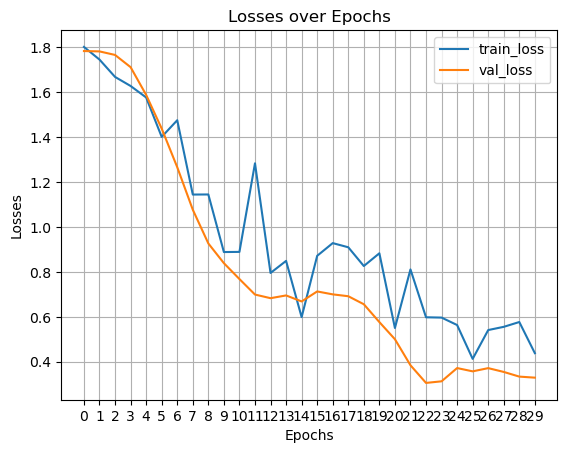

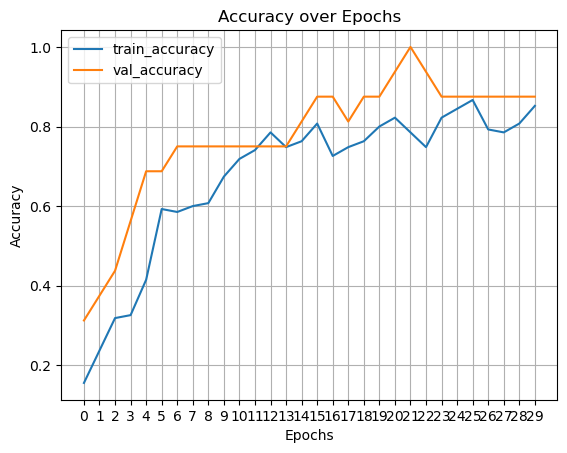

In [32]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 5))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [26]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [27]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Colour: {label_to_colour[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_colour[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_colour[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

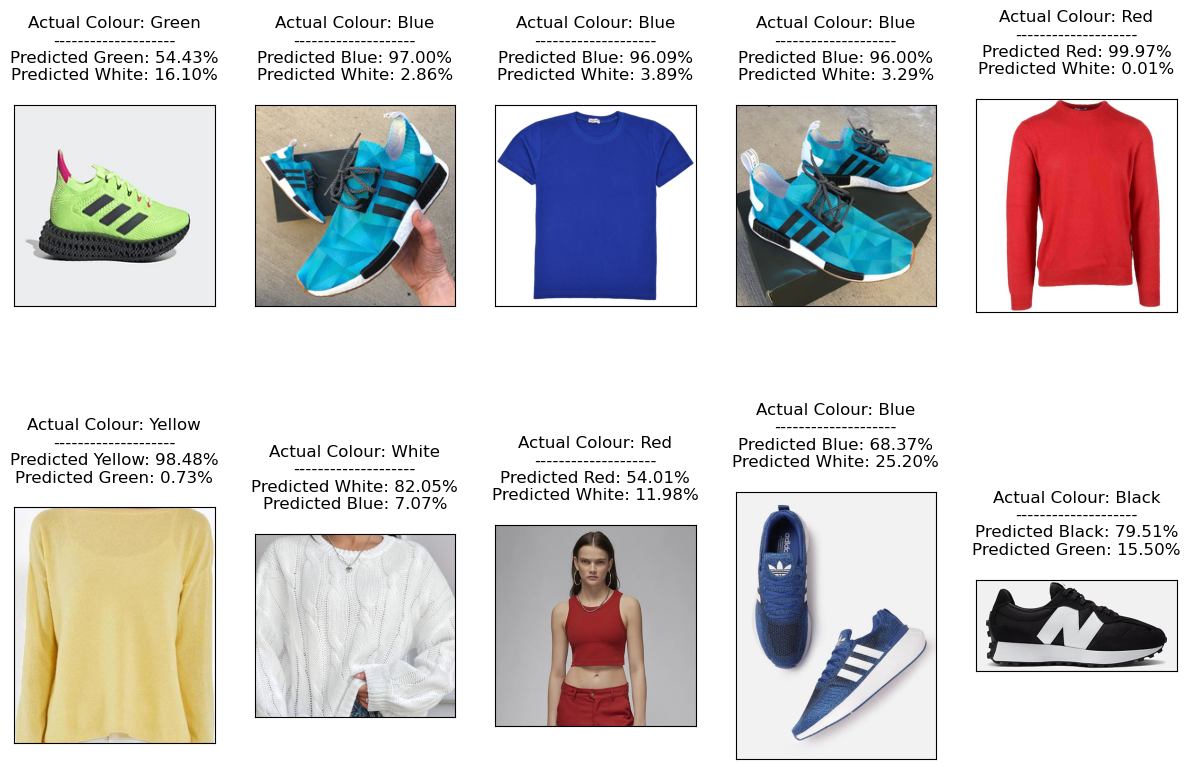

In [28]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)